In [2]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('white')
sns.set_context('talk')
FIGSIZE = (6, 4.8)

# Camera ready submissions often require specific text formatting in plots, which this provides.
# Also lets us use latex in the plots as an added bonus.
plt.rc('text', usetex=True)

wandb_api = wandb.Api()

In [52]:
def get_exp_data(exp_names, metrics):
#     exp_runs = wandb_api.runs(path='robbycostales/dorl-hw1', filters={'$or': [{'name': curr_tag} for curr_tag in exp_names]})
    exp_runs = wandb_api.runs(path='robbycostales/dorl-hw1')
    print(len(exp_runs))
    run_counter = {}
    df = pd.DataFrame()
    for run in exp_runs:
        curr_tag = run.name
        
        if 'i002' not in run.name:
            continue
        
#         curr_df = run.history(keys=list(metrics.keys()), samples=1000)
        curr_df = run.history()

        if len(curr_df) == 0:
            print("No data:", run.name, curr_tag)
            # maybe run crashed
            continue
            
        print("YAY DATA", run.name, curr_tag)
        curr_df.loc[:, 'Name'] = run.name
        curr_df.loc[:, 'Tag'] = curr_tag
        curr_df.loc[:, 'Method'] = exp_names[curr_tag]
        run_counter[curr_tag] = run_counter.get(curr_tag, 0) + 1
        curr_df.loc[:, 'Run'] = run_counter[curr_tag]
        curr_df = curr_df.rename(columns={'_step': 'Step', **metrics})
        df = df.append(curr_df)
    return df


In [9]:
def smooth_data(df, metrics, smooth_alpha=0.1):
#     print(df.head())
    # Apply smoothing to each run independently (to prevent bleeding across runs)
    smooth_df = df.copy()
    # early data will be skewed by first value, so use mean of first (1/smooth_alpha) values as the init
    def ewm_with_init(data):
#         first_n = int(1 / smooth_alpha)
#         data.loc[-1] = data[:first_n].mean()
        return data.ewm(alpha=smooth_alpha).mean()  # .iloc[1:]
        
    smooth_df.loc[:, tuple(metrics.values())] = smooth_df.groupby(['Method', 'Run'])[tuple(metrics.values())].transform(
        ewm_with_init)
    return smooth_df

In [5]:
def align_data(df, keep_short=False):
    aligned_df = pd.DataFrame()

    for method in df.Method.unique():
        method_df = df[df.Method == method]
        run_nums = method_df.Run.unique()
        # find run that ends latest to align to
        base_run = method_df[method_df.Step == method_df.Step.max()].Run.values[0]
        base_df = method_df[method_df.Run == base_run].set_index('Step')
        aligned_df = aligned_df.append(base_df)
        for run_num in run_nums:
            if run_num == base_run:
                continue
            curr_df = method_df[method_df.Run == run_num].set_index('Step')
            _, al_df = base_df.align(curr_df, axis=0, method='pad')
            al_df = al_df.loc[base_df.index]
            al_df = al_df.iloc[:len(curr_df)]
            if len(curr_df) < 0.98 * len(base_df) and not keep_short:
                continue
            aligned_df = aligned_df.append(al_df)

    return aligned_df.reset_index()


In [6]:
def set_init_values(df):
    min_values = df.min()
    max_values = df.max()
    def apply_this(sub_df):
        sub_df = sub_df.copy()
        if 'Success Rate' in sub_df.columns:
            sub_df.loc[sub_df.index[0], 'Success Rate'] = min_values['Success Rate']
        if 'Episode Length' in sub_df.columns:
            sub_df.loc[sub_df.index[0], 'Episode Length'] = max_values['Episode Length']
        return sub_df
    return df.groupby(['Method', 'Run']).apply(apply_this)

def subsample_data(df, subsamp_factor=1):
    return df.groupby(['Method', 'Run']).apply(
        lambda x: x[::subsamp_factor])

In [54]:
metrics = {'train_loss': 'Train Loss',
           'test_loss': 'Test Loss',
           'test_acc': 'Test Accuracy'}

no_blur = '0 Epochs'
ep5 = '5 Epochs'
ep50 = '50 Epochs'

exp_names = {'results/i002_no-blur/': no_blur,
             'results/i002_5-blur/': ep5,
             'results/i002_50-blur/': ep50,
            }

df = subsample_data(
    align_data(
        smooth_data(
            get_exp_data(exp_names, metrics),
            metrics,
            smooth_alpha=0.05)),
    subsamp_factor=1)

14
YAY DATA results/i002_50-blur/ results/i002_50-blur/
YAY DATA results/i002_5-blur/ results/i002_5-blur/
YAY DATA results/i002_no-blur/ results/i002_no-blur/
YAY DATA results/i002_50-blur/ results/i002_50-blur/
YAY DATA results/i002_no-blur/ results/i002_no-blur/
    step  Step  Train Loss  _runtime  epoch  _timestamp  Test Loss  \
0   69.0    69    2.650193        72      0  1644478432        NaN   
1  328.0   328    1.897464       310      0  1644478670        NaN   
2  355.0   355    1.672459       337      0  1644478697        NaN   
3  402.0   404    1.880237       386      1  1644478746        NaN   
4  491.0   493    1.739466       480      1  1644478840        NaN   

                    Name                    Tag     Method  Run  Test Accuracy  
0  results/i002_50-blur/  results/i002_50-blur/  50 Epochs    1            NaN  
1  results/i002_50-blur/  results/i002_50-blur/  50 Epochs    1            NaN  
2  results/i002_50-blur/  results/i002_50-blur/  50 Epochs    1       

<ipython-input-9-46117769e90d>:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  smooth_df.loc[:, tuple(metrics.values())] = smooth_df.groupby(['Method', 'Run'])[tuple(metrics.values())].transform(


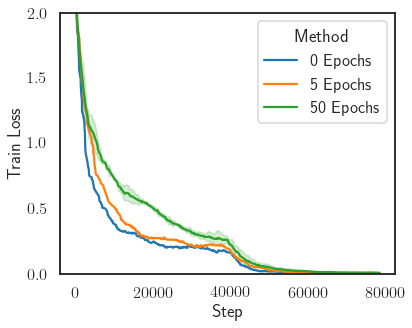

In [60]:
plot_order = [ 
    no_blur, 
    ep5, 
    ep50
]


plt.figure(figsize=(6, 4.8))
# plt.xlim(0, firefighter_ret_df.Step.max()-2_500_000)
plt.ylim(0, 2.0)

# palette=sns.color_palette('tab10')[0:3] + sns.color_palette('tab10')[4:6]

sns.lineplot(data=df, x='Step', y='Train Loss', hue='Method', hue_order=plot_order, legend='brief', estimator=np.median, n_boot=3000, ci='sd') #, ci='sd')
plt.show()
# plt.legend(bbox_to_anchor=(1., 1.));
# plt.savefig('../icml/figs/firefighter_success_rate.pdf', bbox_inches='tight', pad_inches=0);

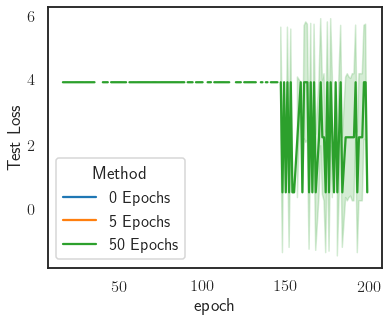

In [63]:
plot_order = [ 
    no_blur, 
    ep5, 
    ep50
]


plt.figure(figsize=(6, 4.8))
# plt.xlim(0, firefighter_ret_df.Step.max()-2_500_000)
# plt.ylim(0, 2.0)

# palette=sns.color_palette('tab10')[0:3] + sns.color_palette('tab10')[4:6]

sns.lineplot(data=df, x='epoch', y='Test Loss', hue='Method', hue_order=plot_order, legend='brief', estimator=np.median, n_boot=3000, ci='sd') #, ci='sd')
plt.show()
# plt.legend(bbox_to_anchor=(1., 1.));
# plt.savefig('../icml/figs/firefighter_success_rate.pdf', bbox_inches='tight', pad_inches=0);